In [1]:
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns

#Definición para el calculo de metricas multi-clase
def calculo_metricas(CM, emociones):
    
    emocion = []
    TruPos = []
    FalPos = []
    FalNeg = []
    TruNeg = []
    acc = []
    prec = []
    recall = []
    f1 = []
    
    total = np.sum(CM)
    
    for i in range(len(emociones)):
       
        TP = CM[i][i]
        FP = sum(CM[:,i])-TP
        FN = sum(CM[i,:])-TP
        TN = total - TP-FN-FP
        a = (TP+TN)/(TP+TN+FN+FP)
        p = TP/(TP+FP)
        r = TP/(TP+FN)
        f = 2*(r*p)/(r+p)
        
        emocion.append(emociones[i])
        TruPos.append(TP)
        FalPos.append(FP)
        TruNeg.append(TN)
        acc.append(a)
        prec.append(p)
        recall.append(r)
        f1.append(f)
    
    metricas = pd.DataFrame()
    metricas['Emociones']=emocion
    metricas['Accuracy']=acc
    metricas['Precision']=prec
    metricas['Recall']=recall
    metricas['F1-Score']=f1
    
    return metricas

def graf_confusion_matrix(CM, emociones,emb):
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(CM,annot=True,fmt='',xticklabels=emociones,yticklabels=emociones, ax=ax, cmap='Blues');
    ax.set_title('Matriz de confusión '+emb);
    ax.set_xlabel('Valores Predecidos');
    ax.set_ylabel('Valores Verdaderos');
    
def graficar_historia_entrenamiento(log, metric='accuracy'):
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    ax1, ax2 = axes
    ax1.plot(log.history['loss'], label='train')
    ax1.plot(log.history['val_loss'], label='test')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(log.history[metric], label='train')
    ax2.plot(log.history['val_'+metric], label='test')
    ax2.set_xlabel('epoch'); ax2.set_ylabel(metric)
    #ax2.set_ylim((0.0, 1.0))
    for ax in axes: ax.legend()

In [3]:
# En esta parte se estan cargando los directorios correspondientes a las 
# imagenes del affectnet tanto el conjunto de entrenamiento como el de 
# validación
train_path = './data/train'
valid_path = './data/test'
train_image_files = glob(train_path +'/*/*.jpg')
valid_image_files = glob(valid_path +'/*/*.jpg')

In [4]:
# Se imprimen para verificar los directorios, existen 6 clases
folders = glob(train_path + '/*')
print(folders)

['./data/train\\0', './data/train\\1', './data/train\\2', './data/train\\3', './data/train\\4', './data/train\\5']


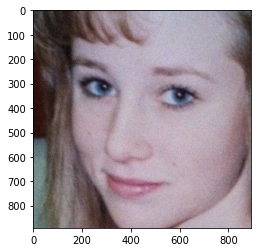

In [5]:
plt.imshow(image.load_img(np.random.choice(valid_image_files)))
plt.show()

In [6]:
IMAGE_SIZE = [48, 48]
#Se crea un Image Generator para incluir el pre-procesamiento de imagenes correspondiente a la arquitectura ResNet
gen = ImageDataGenerator()

In [7]:
#Se crean los generadores deimagenes a partir  de los directorios
# con un batch-size de 128
batch_size = 128

#Generador para el conjunto de entrenamiento
train_generator = gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode = 'sparse'
)
# Generador para el conjunto de validación
valid_generator = gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode = 'sparse'
)

Found 39864 images belonging to 6 classes.
Found 4983 images belonging to 6 classes.


In [8]:
from tensorflow.keras.layers import Activation, Convolution2D, Dropout, Conv2D
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

In [9]:
#Modeo mi-Xception extraido de (https://github.com/oarriaga/face_classification/tree/master/src/models)
def mini_XCEPTION(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)

    # base
    img_input = Input(input_shape)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3),
               # kernel_regularizer=regularization,
               padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax', name='predictions')(x)

    model = Model(img_input, output)
    return model

In [10]:
#Instancia del modelo 1: mini_XCEPTION
miniXception = mini_XCEPTION(input_shape=(48,48,3), num_classes=6)
miniXception.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 46, 46, 8)    216         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 46, 46, 8)    32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 46, 46, 8)    0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

#Callabacks
patience = 10
early_stop = EarlyStopping('val_loss',patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss',factor=0.1, patience=int(patience/4), verbose=1)
callbacks = [early_stop, reduce_lr]

miniXception.compile(optimizer='adam', 
                     loss='sparse_categorical_crossentropy', 
                     metrics=[tf.keras.metrics.sparse_categorical_accuracy])

log_r = miniXception.fit(train_generator,
                         batch_size=128,
                         epochs=20, 
                         verbose=1, 
                         callbacks=callbacks,
                         validation_data=valid_generator)

Epoch 1/20
312/312 [==============================] - 736s 2s/step - loss: 1.7057 - sparse_categorical_accuracy: 0.3359 - val_loss: 1.8564 - val_sparse_categorical_accuracy: 0.2336
Epoch 2/20
312/312 [==============================] - 372s 1s/step - loss: 1.4569 - sparse_categorical_accuracy: 0.4410 - val_loss: 1.5558 - val_sparse_categorical_accuracy: 0.4088
Epoch 3/20
312/312 [==============================] - 392s 1s/step - loss: 1.3541 - sparse_categorical_accuracy: 0.4792 - val_loss: 1.4192 - val_sparse_categorical_accuracy: 0.4555
Epoch 4/20
312/312 [==============================] - 380s 1s/step - loss: 1.2797 - sparse_categorical_accuracy: 0.5099 - val_loss: 1.4683 - val_sparse_categorical_accuracy: 0.4254
Epoch 5/20
312/312 [==============================] - 369s 1s/step - loss: 1.2275 - sparse_categorical_accuracy: 0.5308 - val_loss: 1.3845 - val_sparse_categorical_accuracy: 0.4840
Epoch 6/20
312/312 [==============================] - 387s 1s/step - loss: 1.1816 - sparse_cate

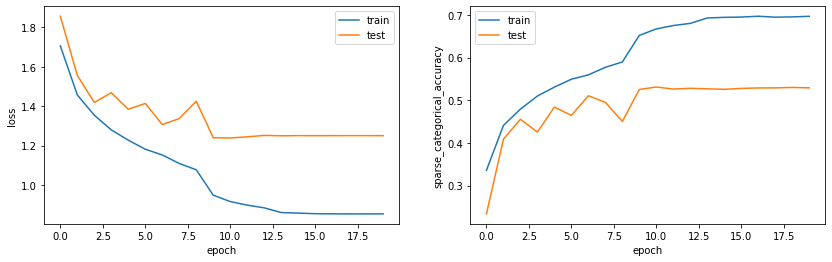

In [14]:
graficar_historia_entrenamiento(log_r, metric='sparse_categorical_accuracy') #, metric='sparse_categorical_accuracy'

In [15]:
N_valid = len(valid_image_files)
Y_valid = np.zeros(N_valid)
Y_pred = np.zeros(N_valid)

i = 0
for x, y in valid_generator:
    pred = miniXception.predict(x)
  
    sz = len(y) 
    Y_pred[i:i+sz]= np.argmax(pred,axis=1)
    Y_valid[i:i+sz]=y

    i += sz
    if i%1280==0:
        print(i)

    if i>=N_valid:
        print('breaking now')
        break

print(i)

1280
2560
3840
breaking now
4983


In [16]:
ind = 235
print(Y_valid[ind], Y_pred[ind])

2.0 2.0


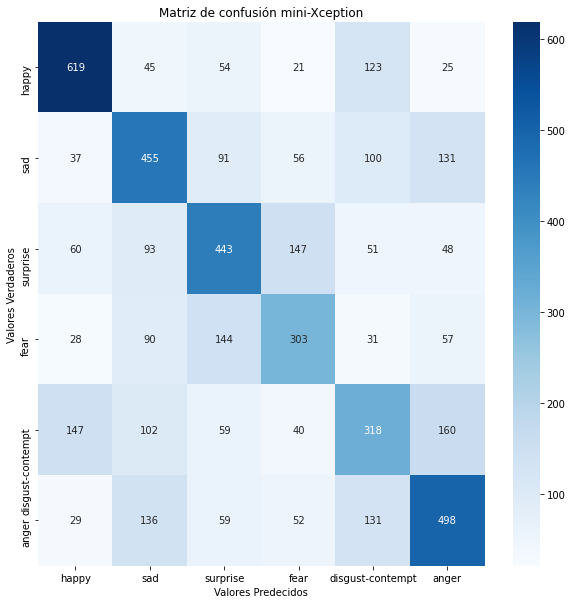

In [17]:
emo_dict = {0: 'happy', 1: 'sad', 2: 'surprise', 3: 'fear', 4: 'disgust-contempt', 5: 'anger'}
emociones_1 = list(emo_dict.values())

CM_mini = confusion_matrix(Y_valid, Y_pred)
graf_confusion_matrix(CM_mini, emociones_1 ,'mini-Xception')

In [18]:
m1 = calculo_metricas(CM_mini, emociones_1)
m1

,Emociones,Accuracy,Precision,Recall,F1-Score
0,happy,0.885812,0.672826,0.697858,0.685113
1,sad,0.823199,0.494028,0.522989,0.508096
2,surprise,0.838250,0.521176,0.526128,0.523641
3,fear,0.866346,0.489499,0.464012,0.476415
4,disgust-contempt,0.810556,0.421751,0.384988,0.402532
5,anger,0.833835,0.541893,0.550276,0.546053


In [19]:
m1.mean()

Accuracy     0.843000
Precision    0.523529
Recall       0.524375
F1-Score     0.523642
dtype: float64

In [20]:
miniXception.save('miniXception_emotions_v2_20epochs.h5')